In [2]:
!nvidia-smi

Tue Jul  2 08:06:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.4     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:91:00.0 Off |                    0 |
| N/A   35C    P0              70W / 400W |    425MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import monai
import torch
from tqdm import tqdm
import pandas as pd
import time

### Data list

In [3]:
csv_path = './mydata/training_sub.csv'
csv = pd.read_csv(csv_path, header=None)
csv.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,tumor_001,6956,130097,0,0,0,0,0,0,0,0,0
1,tumor_001,72896,126272,0,0,0,0,0,0,0,0,0
2,tumor_001,64028,128206,0,0,0,0,0,0,0,0,0
3,tumor_001,71708,124396,1,1,1,0,1,1,1,1,1
4,tumor_001,73408,127040,0,0,0,0,0,0,0,0,0


In [4]:
train_data_list = monai.data.CSVDataset(
        './mydata/training_sub.csv',
        col_groups={"image": 0, "location": [2, 1], "label": [3, 6, 9, 4, 7, 10, 5, 8, 11]},
        kwargs_read_csv={"header": None},
        transform=monai.transforms.Lambdad("image", lambda x: os.path.join('mydata', x + ".tif")),
    )

### Transforms
"CuCIM transform only work with CuPy arrays, so this transform expects input data to be cupy.ndarray"
</br> Ref: https://docs.monai.io/en/stable/transforms.html

In [5]:
trans_cucim = monai.transforms.Compose(
            [
                monai.transforms.ToCupyd(keys='image', dtype=np.float32),
                monai.transforms.CuCIMd(keys='image', name="scale_intensity_range", a_min=0.0, a_max=255.0, b_min=-1.0, b_max=1.0),
                monai.transforms.RandCuCIMd(keys='image', name='rand_zoom', min_zoom=0.9, max_zoom=1.1, prob=1.),
                monai.transforms.ToTensord(keys='image', device='cuda'),
            ]
        )

### Dataset and DataLoader

In [6]:
ds = monai.data.PatchWSIDataset(train_data_list, transform=trans_cucim, patch_size=224, patch_level=0, reader='cuCIM')
dl = torch.utils.data.DataLoader(ds, batch_size=64)

In [7]:
sample = ds[0]
sample.keys()

dict_keys([image, label])

In [8]:
sample['image'].shape

torch.Size([3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


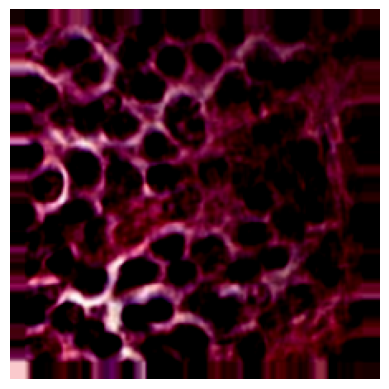

In [9]:
patch = sample['image'].cpu().numpy().transpose([1, 2, 0])
print(patch.shape)
plt.imshow(patch)
plt.axis('off')
plt.show()

### Network, loss and optimizer
Fix the network setting. Ref: https://docs.monai.io/en/stable/networks.html#unet

In [10]:
device = torch.device("cuda:0")

model = monai.networks.nets.TorchVisionFCModel(
    model_name='resnet18',
    num_classes=len(sample['label']),
    use_conv=True,
    pretrained=True
).to(device)
model.eval()
with torch.no_grad():
    output = model(sample['image'][None])
    
output.shape

torch.Size([1, 9, 1, 1])

In [11]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

### Training

In [ ]:
max_epochs = 10
epoch_loss_values = []

# Set to training mode
model.train()
t1 = time.time()
for epoch in range(max_epochs):
    print('Epoch: '+str(epoch+1)+'/'+str(max_epochs))
    epoch_loss = 0
    for step, batch_data in enumerate(dl):
        inputs, labels = (
            batch_data["image"],
            batch_data["label"].to(device)
        )
        # Reset optimizer 
        optimizer.zero_grad()
        # Forward
        outputs = model(inputs).squeeze([2, 3])
        # Loss
        loss = loss_function(outputs, labels)
        # Backward
        loss.backward()
        # Update weights
        optimizer.step()
        epoch_loss += loss.item()
        print('  Step '+str(step+1)+'/'+str(len(dl))+f', train_loss: {loss.item():.4f}')
    epoch_loss /= (step+1)
    epoch_loss_values.append(epoch_loss)
t2 = time.time()

Timespan: 253.3082 seconds


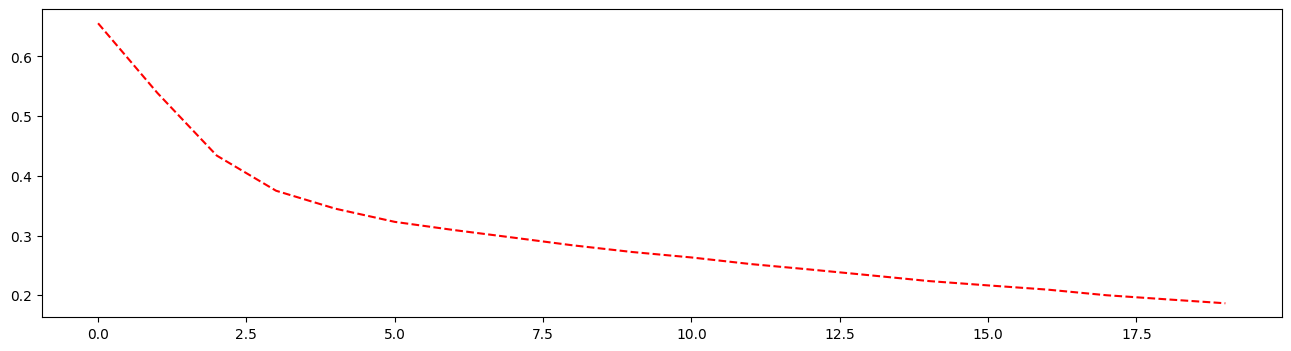

In [13]:
plt.figure(figsize=(16, 4))
plt.plot(epoch_loss_values, ls='--', c='r')
print('Timespan:', round(t2-t1, 4), 'seconds')

In [14]:
labels[:10]

tensor([[1., 0., 0., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 1., 1., 0., 1., 1., 1.],
        [0., 0., 1., 0., 1., 1., 1., 1., 1.],
        [0., 1., 1., 0., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 1., 1., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [15]:
(torch.sigmoid(outputs[:10])>0.5).float()

metatensor([[0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 1., 1., 0.],
        [0., 1., 1., 0., 1., 1., 1., 1., 0.],
        [0., 1., 1., 0., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')

In [1]:
TH = 0.5
(labels==(torch.sigmoid(outputs)>TH).float()).sum()/(labels.shape[0]*labels.shape[1])